In [66]:
import pygsti
from pygsti.circuits import Circuit
import random
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from pygsti.tools.lindbladtools import *
from pygsti.baseobjs.basisconstructors import id2x2, sigmax, sigmay, sigmaz
from pygsti.modelmembers.operations import LindbladErrorgen
from tqdm import tqdm
SigX = np.array([[0, 1], [1, 0]], dtype=complex)
SigY = np.array([[0, -1j], [1j, 0]], dtype=complex)
SigZ = np.array([[1, 0], [0, -1]], dtype=complex)

In [67]:
import numpy as _np
import scipy.sparse as _sps

from pygsti.tools import matrixtools as _mt
from pygsti.tools.basistools import basis_matrices

In [68]:
def create_elementary_errorgen_pp(typ, p, q=None, sparse=False):
    """
    Construct an elementary error generator as a matrix in the "pauli product" basis.
    There are four different types of elementary error generators: 'H' (Hamiltonian),
    'S' (stochastic), 'C' (correlation), and 'A' (active).  See arxiv:2103.01928.
    Each type transforms an input density matrix differently.  The action of an elementary
    error generator `L` on an input density matrix `rho` is given by:
    Hamiltonian:  `L(rho) = -1j * [ p, rho ]`
    Stochastic:   `L(rho) = p * rho * p - rho
    Correlation:  `L(rho) = p * rho * q + q * rho * p - 0.5 {{p,q}, rho}
    Active:       `L(rho) = 1j( p * rho * q - q * rho * p + 0.5 {[p,q], rho} )
    Square brackets denotes the commutator and curly brackets the anticommutator.
    `L` is returned as a superoperator matrix that acts on vectorized density matrices.
    Parameters
    ----------
    typ : {'H','S','C','A'}
        The type of error generator to construct.
    p : numpy.ndarray
        d-dimensional basis matrix.
    q : numpy.ndarray, optional
        d-dimensional basis matrix; must be non-None if and only if `typ` is `'C'` or `'A'`.
    sparse : bool, optional
        Whether to construct a sparse or dense (the default) matrix.
    Returns
    -------
    ndarray or Scipy CSR matrix
    """
    d = p.shape[0]; d2 = d**2
    if sparse:
        elem_errgen = _sps.lil_matrix((d2, d2), dtype=p.dtype)
    else:
        elem_errgen = _np.empty((d2, d2), dtype=p.dtype)

    assert(typ in ('H', 'S', 'C', 'A')), "`typ` must be one of 'H', 'S', 'C', or 'A'"
    assert((typ in 'HS' and q is None) or (typ in 'CA' and q is not None)), \
        "Wrong number of basis elements provided for %s-type elementary errorgen!" % typ

    pdag = p.T.conjugate()
    qdag = q.T.conjugate() if (q is not None) else None

    if typ in 'CA':
        pq_plus_qp = pdag @ q + qdag @ p
        pq_minus_qp = pdag @ q - qdag @ p

    # Loop through the standard basis as all possible input density matrices
    for i, rho0 in enumerate(basis_matrices('std', d2)):  # rho0 == input density mx
        # Only difference between H/S/C/A is how they transform input density matrices
        if typ == 'H':
            rho1 = -1j * (p @ rho0 - rho0 @ p)  # Add "/2" to have PP ham gens match previous versions of pyGSTi
        elif typ == 'S':
            pdag_p = (pdag @ p)
            rho1 = p @ rho0 @ pdag - 0.5 * (pdag_p @ rho0 + rho0 @ pdag_p)
        elif typ == 'C':
            rho1 = p @ rho0 @ qdag + q @ rho0 @ pdag - 0.5 * (pq_plus_qp @ rho0 + rho0 @ pq_plus_qp)
        elif typ == 'A':
            rho1 = 1j * (p @ rho0 @ qdag - q @ rho0 @ pdag + 0.5 * (pq_minus_qp @ rho0 + rho0 @ pq_minus_qp))

        elem_errgen[:, i] = rho1.flatten()[:, None] if sparse else rho1.flatten()

    if sparse: elem_errgen = elem_errgen.tocsr()
    return np.round(pygsti.tools.change_basis(elem_errgen, 'std', 'pp'), 12)

def create_elementary_errorgen_dual_pp(typ, p, q=None, sparse=False, normalization_factor='auto'):
    """
    Construct a "dual" elementary error generator matrix in the "pauli product"  basis.
    The elementary error generator that is dual to the one computed by calling
    :function:`create_elementary_errorgen` with the same argument.  This dual element
    can be used to find the coefficient of the original, or "primal" elementary generator.
    For example, if `A = sum(c_i * E_i)`, where `E_i` are the elementary error generators given
    by :function:`create_elementary_errorgen`), then `c_i = dot(D_i.conj(), A)` where `D_i`
    is the dual to `E_i`.
    There are four different types of dual elementary error generators: 'H' (Hamiltonian),
    'S' (stochastic), 'C' (correlation), and 'A' (active).  See arxiv:2103.01928.
    Each type transforms an input density matrix differently.  The action of an elementary
    error generator `L` on an input density matrix `rho` is given by:
    Hamiltonian:  `L(rho) = -1j/(2d^2) * [ p, rho ]`
    Stochastic:   `L(rho) = 1/(d^2) p * rho * p
    Correlation:  `L(rho) = 1/(2d^2) ( p * rho * q + q * rho * p)
    Active:       `L(rho) = 1j/(2d^2) ( p * rho * q - q * rho * p)
    where `d` is the dimension of the Hilbert space, e.g. 2 for a single qubit.  Square
    brackets denotes the commutator and curly brackets the anticommutator.
    `L` is returned as a superoperator matrix that acts on vectorized density matrices.
    Parameters
    ----------
    typ : {'H','S','C','A'}
        The type of dual error generator to construct.
    p : numpy.ndarray
        d-dimensional basis matrix.
    q : numpy.ndarray, optional
        d-dimensional basis matrix; must be non-None if and only if `typ` is `'C'` or `'A'`.
    sparse : bool, optional
        Whether to construct a sparse or dense (the default) matrix.
    Returns
    -------
    ndarray or Scipy CSR matrix
    """
    d = p.shape[0]; d2 = d**2
    pdag = p.T.conjugate()
    qdag = q.T.conjugate() if (q is not None) else None

    if sparse:
        elem_errgen = _sps.lil_matrix((d2, d2), dtype=p.dtype)
    else:
        elem_errgen = _np.empty((d2, d2), dtype=p.dtype)

    assert(typ in ('H', 'S', 'C', 'A')), "`typ` must be one of 'H', 'S', 'C', or 'A'"
    assert((typ in 'HS' and q is None) or (typ in 'CA' and q is not None)), \
        "Wrong number of basis elements provided for %s-type elementary errorgen!" % typ

    # Loop through the standard basis as all possible input density matrices
    for i, rho0 in enumerate(basis_matrices('std', d2)):  # rho0 == input density mx
        # Only difference between H/S/C/A is how they transform input density matrices
        if typ == 'H':
            rho1 = -1j * (p @ rho0 - rho0 @ p)  # -1j / (2 * d2) *
        elif typ == 'S':
            rho1 = (p @ rho0 @ pdag)  # 1 / d2 *
        elif typ == 'C':
            rho1 = (p @ rho0 @ qdag + q @ rho0 @ pdag)  # 1 / (2 * d2) *
        elif typ == 'A':
            rho1 = 1j * (p @ rho0 @ qdag - q @ rho0 @ pdag)  # 1j / (2 * d2)
        elem_errgen[:, i] = rho1.flatten()[:, None] if sparse else rho1.flatten()

    return_normalization = bool(normalization_factor == 'auto_return')
    if normalization_factor in ('auto', 'auto_return'):
        primal = create_elementary_errorgen(typ, p, q, sparse)
        if sparse:
            normalization_factor = _np.vdot(elem_errgen.toarray().flatten(), primal.toarray().flatten())
        else:
            normalization_factor = _np.vdot(elem_errgen.flatten(), primal.flatten())
    elem_errgen *= _np.real_if_close(1 / normalization_factor).item()  # item() -> scalar
    elem_errgen = np.round(pygsti.tools.change_basis(elem_errgen, 'std', 'pp'), 12)

    if sparse: elem_errgen = elem_errgen.tocsr()
    return (elem_errgen, normalization_factor) if return_normalization else elem_errgen

In [69]:
def pstr_to_mat(pstr):
    pmat = 1
    for pchar in pstr:
        if pchar == 'X':
            pmat = np.kron(pmat, SigX)
        elif pchar == 'Y':
            pmat = np.kron(pmat, SigY)
        elif pchar == 'Z':
            pmat = np.kron(pmat, SigZ)
        else:
            pmat = np.kron(pmat, np.array([[1, 0], [0, 1]], dtype=complex))
    return pmat

def egenlbl_to_mat(lbl, num_qubits):
    egen_type = lbl.errorgen_type
    egen_basis_lbls = lbl.basis_element_labels
    egen_support = lbl.support
    # convert the basis labels into Pauli strings
    pstr1 = ['I']*num_qubits
    for i, pchar in enumerate(egen_basis_lbls[0]):
        pstr1[egen_support[i]] = pchar
    pstr1 = ''.join(pstr1)
    pmat1 = pstr_to_mat(pstr1)
    if egen_type in 'CA':
        pstr2 = ['I']*num_qubits
        for i, pchar in enumerate(egen_basis_lbls[1]):
            pstr2[egen_support[i]] = pchar
        pstr2 = ''.join(pstr2)
        pmat2 = pstr_to_mat(pstr2)
        return create_elementary_errorgen_pp(egen_type, pmat1, pmat2)
    else:
        return create_elementary_errorgen_pp(egen_type, pmat1)
    
def egenlbl_to_dual(lbl, num_qubits):
    egen_type = lbl.errorgen_type
    egen_basis_lbls = lbl.basis_element_labels
    egen_support = lbl.support
    # convert the basis labels into Pauli strings
    pstr1 = ['I']*num_qubits
    for i, pchar in enumerate(egen_basis_lbls[0]):
        pstr1[egen_support[i]] = pchar
    pstr1 = ''.join(pstr1)
    pmat1 = pstr_to_mat(pstr1)
    if egen_type in 'CA':
        pstr2 = ['I']*num_qubits
        for i, pchar in enumerate(egen_basis_lbls[1]):
            pstr2[egen_support[i]] = pchar
        pstr2 = ''.join(pstr2)
        pmat2 = pstr_to_mat(pstr2)
        return create_elementary_errorgen_dual_pp(egen_type, pmat1, pmat2)
    else:
        return create_elementary_errorgen_dual_pp(egen_type, pmat1)

In [70]:
# dual basis returns a negative rate ???
print(np.trace(create_elementary_errorgen_pp('A', SigZ, SigX)@create_elementary_errorgen_dual_pp('A', SigZ, SigX)))
# seems to work for conjugate of the dual
print(np.trace(create_elementary_errorgen_pp('A', SigZ, SigX).conj().T@create_elementary_errorgen_dual_pp('A', SigZ, SigX)))

-1.0
1.0


In [71]:
class ErrorGen():
    """
    Implements the small Markovian taxonomy
    
    Parameters:
        -features: pauli transfer representations for different error processes
        -rates: sympy vector of rates
    """
    
    def __init__(self, num_qubits, gate_label=('G', 0), parameterization='HSCA'):
        """
        setup the feature dictionary with keys that are sympy variables
        """
        self.num_qubits = num_qubits
        self.label_map = dict() # maps params to corresponding pygsti labels
        self.labels =  LindbladErrorgen.from_error_generator(4**num_qubits).coefficient_labels()
        self.params = []
        for lbl in self.labels:
            if len(lbl.basis_element_labels) > 1:
                pstr1 = str()
                pstr2 = str()
                lbl1 = lbl.basis_element_labels[0]
                lbl2 = lbl.basis_element_labels[1]
                if len(lbl1) < num_qubits:
                    flg = 0
                    for i in range(num_qubits):
                        if i in lbl.support:
                            pstr1 += lbl1[flg]
                            flg += 1
                        else:
                            pstr1 += 'I'
                else:
                    pstr1 = lbl.basis_element_labels[0]
                if len(lbl2) < num_qubits:
                    flg = 0
                    for i in range(num_qubits):
                        if i in lbl.support:
                            pstr2 += lbl2[flg]
                            flg += 1
                        else:
                            pstr2 += 'I'
                else:
                    pstr2 = lbl.basis_element_labels[1]
                pstr = pstr1 + 'x' + pstr2
            else:
                pstr = str()
                flg = 0
                for idx in range(num_qubits):
                    if idx in lbl.support:
                        pstr += lbl.basis_element_labels[0][flg]
                        flg += 1
                    else: 
                        pstr += 'I'
            if len(gate_label) > 1:
                gstr = str(gate_label[0]) + 'q' + str(gate_label[1])
            else:
                gstr = gate_label[0]
            param = sp.symbols(f'{{{lbl.errorgen_type}}}^{{{pstr}}}_{{{gstr}}} ')
            self.params.append(param)
            self.label_map[param] = lbl   
            
    def __len__(self):
        return len(self.params)
            
    @property
    def vec(self):
        return list(self.params)
    
    @property
    def mat(self):
        mat = np.zeros((4**self.num_qubits, 4**self.num_qubits), dtype='O')
        for x in self.vec:
            mat += x*self.feature_map[x]
        return sp.Matrix(mat)
    
    @property
    def features(self):
        return [egenlbl_to_mat(lbl, self.num_qubits) for lbl in self.labels]
    
    @property
    def dual_features(self):
        return [egenlbl_to_dual(lbl, self.num_qubits) for lbl in self.labels]
    
    def feature_of_param(self, param):
        return egenlbl_to_mat(self.label_map[param], self.num_qubits)
    
    def extract_rates(self):
        rates = dict()
        gen = self.mat
        for lbl in tqdm(self.labels):
            dgen = egenlbl_to_dual(lbl, self.num_qubits)
            rates[lbl] = np.trace(dgen.conj().T@gen)
        return rates
        

In [72]:
class GateSet():
    """
    Holds the information for
        -all native gates, states, and measurements
        -all error generator features (in a feature dict)
        -map between gate labels and parameter index list (index set)
        -map between parameter indices and error features (feature dict) 
        
    TODO: generalize to n-qubits
    """
    def __init__(self, model_pack):
        # A list of error rates, each one corresponding to one feature in the above list
        self.rates = []
        self.gate_errors = dict() # maps gate parameters to error generators
        self.target_model = model_pack.target_model('CPTP')
        self.gate_labels = model_pack.gates
        self.num_qubits = model_pack.processor_spec().num_qubits
        
        # Errors generators for all gates in the model
        for gate in model_pack.gates:
            if len(gate) <= 1:
                egen = ErrorGen(self.num_qubits, (gate, ''))
            else:
                egen = ErrorGen(self.num_qubits, gate)
            self.gate_errors[gate] = egen
            self.rates += egen.vec
        # Errors for all measurements in the model
        for povm in self.target_model.povms.keys():
            egen = ErrorGen(self.num_qubits, (povm, 'M'))
            self.gate_errors[povm] = egen
            self.rates += egen.vec
        # Errors for all state preparations in the model
        for prep in self.target_model.preps.keys():
            egen = ErrorGen(self.num_qubits, (prep, 'P'))
            self.gate_errors[prep] = egen
            self.rates += egen.vec
            
    @property
    def vec(self):
        return self.rates
    
    @property
    def num_params(self):
        return len(self.vec)
    
    def features_of(self, op_label):
        """Returns the list of error features associated with the given gate/POVM/state-prep"""
        return self.gate_errors[op_label].features
    
    def rates_of(self, op_label):
        """Returns the list of error rates associated with the given gate/POVM/state-prep"""
        return self.gate_errors[op_label].vec
    
    def error_matrix_of(self, op_label):
        """Returns the error generator matrix associated with the given gate/POVM/state-prep"""
        return self.gate_errors[op_label].mat
    
    def target_op(self, op_label):
        """
        returns the target operation of the given operation
        """
        return self.target_model[op_label].to_dense()

    def native_meas(self):
        return [m.to_dense() for m in self.target_model['Mdefault'].values()]

    def rho0(self):
        return self.target_model['rho0'].to_dense()

We'll define the adjoint $\text{Ad}_U$ map of a unitary gate $U$ according to 
$$
    \text{Ad}_U(X) \equiv U X U^{-1}. 
$$
In terms of the adjoint action on a basis
$$
    \text{Ad}_U(x^i e_i) = x^i U L_i U^{-1}.
$$
Now, let us consider a vector representation of the algebra
$$
    x^i L_i \equiv z^j e_j
$$
then we have the correspondence
$$
    \text{Ad}_U \equiv R(U)
$$
so that 
$$
    R(U)_i^j e_i \equiv U L_i U^\dagger. 
$$

We may define the components of $R(U)$ as
$$
    R(U)^i_j = \langle L^i , U L_j U^\dagger \rangle
$$


Proof that $\text{Ad}_{U_2 U_1} = \text{Ad}_{U_1} \circ \text{Ad}_{U_2}$:
$$
    \text{Ad}_{U_2 U_1} = U_2 U_1 X U_1^\dagger U_2^\dagger = \text{Ad}_{U_2}(U_1 X U_1^\dagger) = \text{Ad}_{U_2} (\text{Ad}_{U_1}(X))
$$

In [73]:
from pygsti.modelpacks import smq1Q_XYZI as std
egen = ErrorGen(1)
gs = GateSet(std)

In [74]:
gs.gate_labels

[(), ('Gxpi2', 0), ('Gypi2', 0), ('Gzpi2', 0)]

In [75]:
def make_adjoint(unitary, egen_basis):
    adjoint = np.zeros((len(egen_basis), len(egen_basis)))
    for id1, df in enumerate(egen_basis.dual_features):
        for id2, f in enumerate(egen_basis.features):
            adjoint[id1, id2] = np.trace(df@unitary@f@np.conj(unitary.T))
    return adjoint

In [76]:
Gx = gs.target_op(('Gxpi2', 0))
Gy = gs.target_op(('Gypi2', 0))
Gz = gs.target_op(('Gzpi2', 0))

In [77]:
Ax = make_adjoint(Gx, egen)
Ay = make_adjoint(Gy, egen)
Az = make_adjoint(Gz, egen)

In [78]:
egen.vec

[{H}^{X}_{Gq0},
 {H}^{Y}_{Gq0},
 {H}^{Z}_{Gq0},
 {S}^{X}_{Gq0},
 {C}^{XxY}_{Gq0},
 {A}^{XxY}_{Gq0},
 {C}^{XxZ}_{Gq0},
 {A}^{XxZ}_{Gq0},
 {S}^{Y}_{Gq0},
 {C}^{YxZ}_{Gq0},
 {A}^{YxZ}_{Gq0},
 {S}^{Z}_{Gq0}]

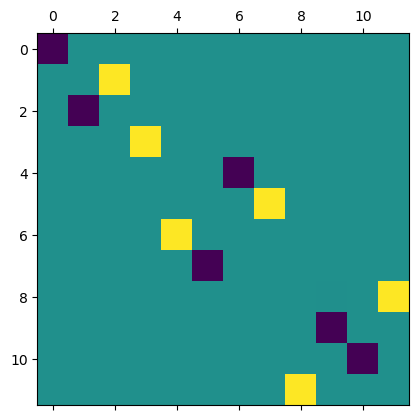

In [79]:
plt.matshow(Ax)

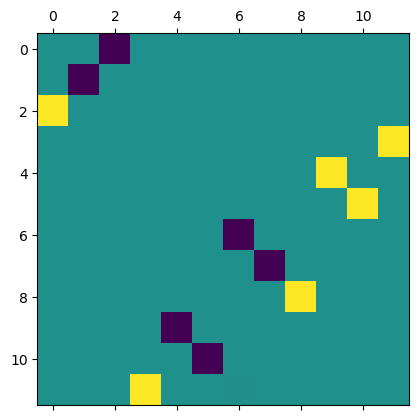

In [80]:
plt.matshow(Ay)

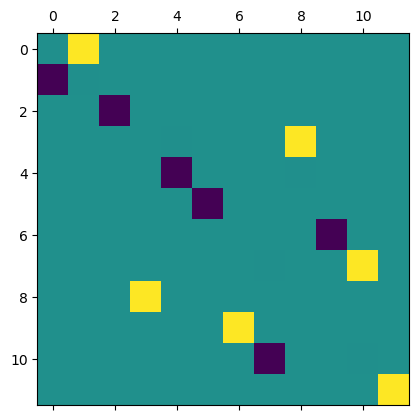

In [81]:
plt.matshow(Az)

In [89]:
H = pygsti.tools.unitary_to_std_process_mx((1/2)*np.array([[1, 1], [1, -1]]))
H = pygsti.tools.basistools.change_basis(H, 'std', 'pp')

In [90]:
Ah = make_adjoint(H, egen)

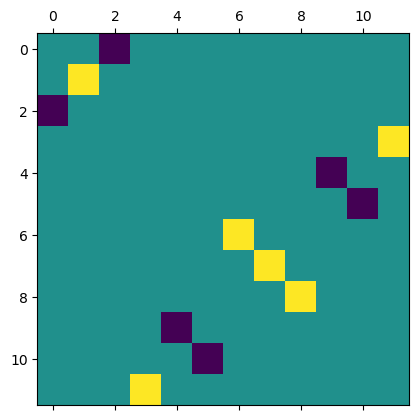

In [91]:
plt.matshow(Ah)

In [94]:
T = pygsti.tools.unitary_to_std_process_mx(np.array([[1, 0], [0, np.exp(1j*np.pi/4)]]))
T = pygsti.tools.basistools.change_basis(T, 'std', 'pp')

In [96]:
At = make_adjoint(T, egen)

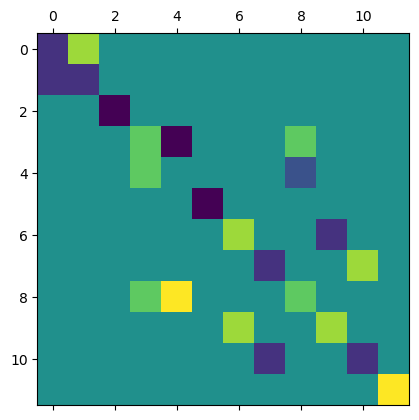

In [97]:
plt.matshow(At)